In [23]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from dlomix.losses import masked_spectral_distance, masked_pearson_correlation_distance


In [15]:
model = keras.saving.load_model('/nfs/home/students/d.lochert/projects/astral/dlomix-astral/saved_models/%s' % 'c_FiLM_full_d10_static_0.0005_z1B.keras', 
                                custom_objects={'masked_spectral_distance': masked_spectral_distance, 'masked_pearson_correlation_distance': masked_pearson_correlation_distance}, compile=True, safe_mode=True)

(1024, 30, 512)
(1024, 1, 5120)


In [8]:
model.summary()

Model: "transformer_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            multiple                  6656      
                                                                 
 dense_21 (Dense)            multiple                  3328      
                                                                 
 dense_22 (Dense)            multiple                  131584    
                                                                 
 trans_block_4 (TransBlock)  multiple                  524545    
                                                                 
 dense_23 (Dense)            multiple                  131584    
                                                                 
 sequential_4 (Sequential)   (1024, 30, 512)           1024      
                                                                 
 dense_24 (Dense)            multiple          

In [9]:
from dlomix.data import FragmentIonIntensityDataset

int_data = FragmentIonIntensityDataset.load_from_disk("/nfs/home/students/d.lochert/projects/astral/dlomix-astral/combined_dataset")

/nfs/home/students/d.lochert/miniconda3/envs/astral/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Avaliable feature extractors are (use the key of the following dict and pass it to features_to_extract in the Dataset Class):
{
   "atom_count": "Atom count of PTM.",
   "delta_mass": "Delta mass of PTM.",
   "mod_gain": "Gain of atoms due to PTM.",
   "mod_loss": "Loss of atoms due to PTM.",
   "red_smiles": "Reduced SMILES representation of PTM."
}.
When writing your own feature extractor, you can either
    (1) use the FeatureExtractor class or
    (2) write a function that can be mapped to the Hugging Face dataset.
In both cases, you can access the parsed sequence information from the dataset using the following keys, which all provide python lists:
    - _parsed_sequence: parsed sequence
    - _n_term_mods: N-terminal modifications
    - _c_term_mods: C-terminal modifications



In [70]:
tmp = [m for m in int_data.tensor_train_data.take(100)][0][0]

res = model.get_meta_vector(tmp)

In [22]:
res.shape


TensorShape([1024, 1, 5120])

In [71]:
res = tf.split(res, 20, axis=-1)

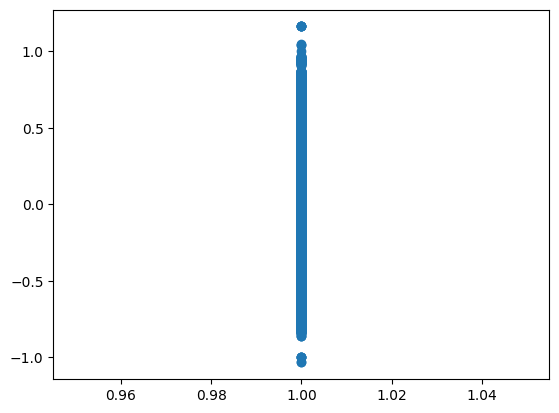

In [38]:
y = tf.reshape(res[0], [-1])
x = [1] * len(y)

plt.scatter(x, y)


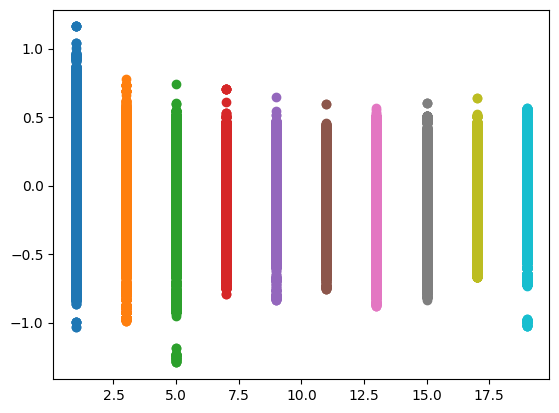

In [57]:
for i in range(0, 20, 2):
    y = tf.reshape(res[i], [-1])
    x = [i+1] * len(y)
    plt.scatter(x, y)

In [79]:
vals = [tf.reshape(res[i], [-1])+1 for i in range(1, 20, 2)]
keys = np.array([i for i in range(1, 11)])


In [61]:
len(vals)
len(keys)

10

{'bodies': [<matplotlib.collections.PolyCollection at 0x7fbc90263100>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7fbcec564c40>,
 'cmins': <matplotlib.collections.LineCollection at 0x7fbcec46dcc0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7fbcec46e1d0>}

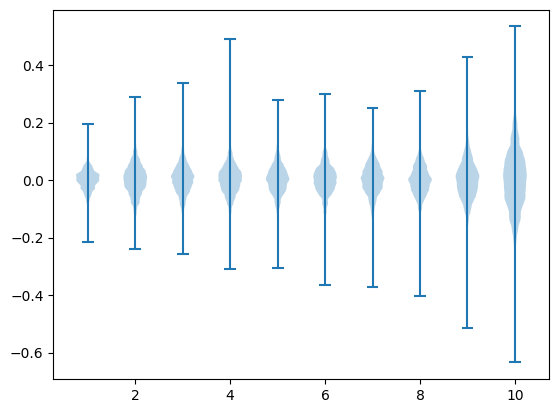

In [75]:
plt.violinplot(vals, keys)

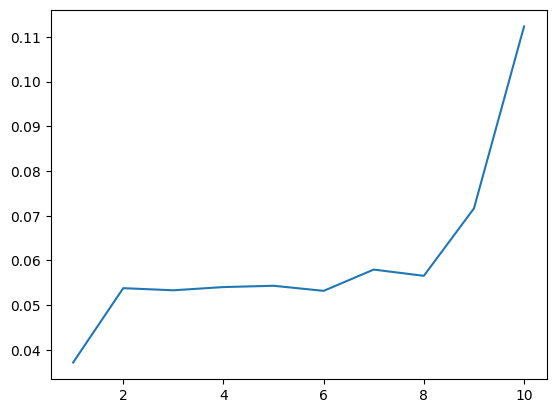

In [80]:
std = [tf.math.reduce_std(v) for v in vals]

plt.plot(keys, std)